# fig5_ivt
AR composites of integrated vapor transport (IVT)


## Imports

In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (after setting, must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

In [6]:
## dictionaries for swapping between anomaly data and non-anomaly data
plot_dict_non_anom = {'fname': 'ERA5/ivt/daily/out.era5*.nc',
                      'clevs_ivt': np.arange(100,601,50),
                      'cmap_ivt': cmo.deep,
                      'quiver_scale': 50,
                      'quiver_key': 250,
                      'quiver_key_lbl': r'250 kg m$^{-1}$ s$^{-1}$',
                      'fig_name_prefix': 'ar_types_ivt_'}

plot_dict_anom = {'fname': 'ERA5/ivt/anomalies/daily_filtered_anomalies_*.nc',
                  'clevs_ivt': np.arange(10,180,10),
                  'cmap_ivt': cmo.deep,
                  'quiver_scale': 10,
                  'quiver_key': 25,
                  'quiver_key_lbl': r'25 kg m$^{-1}$ s$^{-1}$',
                  'fig_name_prefix': 'anom_ar_types_ivt_'}
plot_dict = plot_dict_non_anom

### ERA5 renalysis

In [7]:
# Select lat/lon grid
lonmin = 30
lonmax = 120
latmin = 0
latmax = 50

### ERA5 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open IVT data
filepath_pattern = path_to_data + plot_dict['fname']
f1 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')


# Create new dataset to rename lat lon
ds = xr.Dataset({'ivte': (['time', 'lat', 'lon'], f1['p71.162'].values),
                  'ivtn': (['time', 'lat', 'lon'], f1['p72.162'].values)},
                  coords={'time': (['time'], f1.time.values),
                          'lat': (['lat'], f1.latitude.values),
                          'lon': (['lon'], f1.longitude.values)})

print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 2.14



### AR days

In [8]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-djf.csv'
df = pd.read_csv(filepath)



In [9]:
# Trim date range
start_date = '1979-12-01'
end_date = '2018-02-28'
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Select DJF months
idx = (ds.time.dt.month >= 12) | (ds.time.dt.month <= 2)
ds = ds.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

In [10]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)
era_ar_lead2 = select_ar_days(era=ds, lag=2)

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    ivte     (time, lat, lon) float32 153.45338 141.90256 ... 110.214935
    ivtn     (time, lat, lon) float32 -128.04677 -118.80045 ... -43.313354
<xarray.Dataset>
Dimensions:  (lat: 101, lon: 181, time: 371)
Coordinates:
  * time     (time) datetime64[ns] 1979-12-01T09:00:00 ... 2018-02-26T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 3 3 1 3 3 2 3 3 3 2 1 3 3 ... 3 3 3 3 3 3 3 1 1 2 2 2
Data variables:
    ivte     (time, lat, lon) 

### Compute AR composites

In [11]:
# Compute composites of each AR type
era_ar_comp_lag0 = era_ar_lag0.groupby('ar').mean('time')
era_ar_comp_lag2 = era_ar_lag2.groupby('ar').mean('time')
era_ar_comp_lead2 = era_ar_lead2.groupby('ar').mean('time')

# combine lag datasets into 1 ds object
era_ar_comp = xr.concat([era_ar_comp_lead2, era_ar_comp_lag0, era_ar_comp_lag2], pd.Index([-2, 0, 2], name='lag'))
era_ar_comp

<xarray.Dataset>
Dimensions:  (ar: 3, lag: 3, lat: 101, lon: 181)
Coordinates:
  * ar       (ar) int64 1 2 3
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
  * lag      (lag) int64 -2 0 2
Data variables:
    ivte     (lag, ar, lat, lon) float32 59.44772 58.09637 ... 44.196945 74.6046
    ivtn     (lag, ar, lat, lon) float32 -5.9898806 -3.307648 ... -29.612562

## Figure 5

### Common plot properties

In [12]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

### Create figure

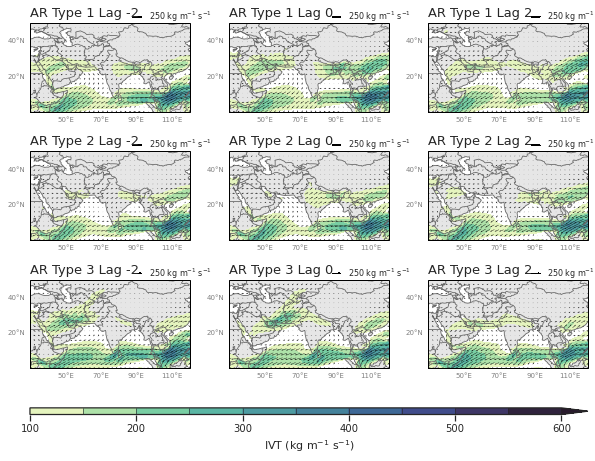

In [13]:
 # Create figure
fig = plt.figure(figsize=(10,11))
nrows = 3
ncols = 3

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='', 
                direction='column')

# loop to draw plots
lag_lst = [-2, -2, -2, 0, 0, 0, 2, 2, 2]
artype_lst = [1, 2, 3, 1, 2, 3, 1, 2, 3]
for k, (ax, lag, ar_type) in enumerate(zip(axgr, lag_lst, artype_lst)):
    data = era_ar_comp.sel(lag=lag, ar=ar_type)
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values
    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
#     print(ivt.min(), ivt.max())
    cf = ax.contourf(lons, lats, ivt, transform=datacrs, extend='max',
                    levels=plot_dict['clevs_ivt'], cmap=plot_dict['cmap_ivt'])
    
    # IVT vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs,
              color='black', regrid_shape=20, pivot='middle',
              angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                      coordinates='axes', fontproperties={'size': 8.0})
    
    # subtitles
    plt_label = 'AR Type {0} Lag {1}'.format(ar_type, lag)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
      
# Save figure
filepath = path_to_figs + plot_dict['fig_name_prefix']+ fname_id + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
    

### Composite EOF using Std Dev

In [26]:
# IVT
uvec = era_eof_comp.ivte.values
vvec = era_eof_comp.ivtn.values
ivt = np.sqrt(uvec**2 + vvec**2)

plt_labels = ['AR EOF1', 'AR EOF2']

NameError: name 'era_eof_comp' is not defined

In [ ]:
 # Create figure
fig = plt.figure(figsize=(10,11))
nrows = 2
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.55,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.0, cbar_size='2.5%',label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # IVT (filled contour)
    clevs_ivt = np.arange(100,601,50)
    cf = ax.contourf(lons, lats, ivt[k,:,:], transform=datacrs,
                    levels=clevs_ivt, cmap=cmo.deep)
    
    # IVT vectors
    ax.quiver(lons, lats, uvec[k,:,:], vvec[k,:,:], transform=datacrs,
        color='black', regrid_shape=20, pivot='middle')
    
    # Subtitles
    ax.set_title(plt_labels[k], loc='left', fontsize=13)
    
    
# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=10)
      
# Save figure
filepath = path_to_figs + 'eof_types_'+ fname_id + '.png'
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
    